# Residential Heat Pump Case Study 1: Hybrid Heating in a Semi-detached Home
Originally Created: 06/2021  
Updated: 11/2021  
By: Erik Janssen  

## 1 Introduction
This Jupyter Notebook was used to analyze the changes in utility consumption pre- and post-retrofit for the hybrid heating  system analyzed in the accompanying case study. The basic process of the analysis is:

1) Import utility data pre- and post-retrofit.  

2) Estimate current utility rates.

3) Create linear regression models of the pre-retrofit and post-retrofit data as a function of heating degree days (HDDs). Use models to estimate results savings for a full heating season. 

4) Adjust the baseline as required to ensure a fair comparison with actual post-retrofit data.  

5) Estimate the fraction of utility savings from hybrid heating specifically (where possible) if more than one measure was implemented.  

6) Ensure that the utility impacts attributed to the hybrid heating system is reasonable by calculating the average COP from the gas savings and electricity increase. Compare the calculated average COP against a temperature-weighted COP calculated from manufacturer data (i.e. an expected COP). The COP calculated from the utility data should be lower than the expected value based on the manufacturer data. Note COP was not explicitly monitored, this is just to ensure that it is reasonable to attribute a certain gas savings to the ASHP based on how much electricity consumption is attributed to it.

7) Calculate other parameters like cost and carbon savings, and perform any other calculations as required.

8) Consider utility implications for carbon pricing scehdule looking out to 2030.


## 2 Libraries

In [80]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import datetime

In [81]:
# Set some basic parameters for plotting and visulizing data
font = {'size'   : 16}
plt.rc('font', **font)
step_blue = "#00a3af"
step_gold = "#f8a81d"
pd.set_option('display.max_columns', None)

## 3 Import Baseline and Post-Retrofit Utility Data

Import the utilty data contained in ".csv" format. The homeowner obtained this data from the Enbridge and Toronto Hydro online portals. Note that the system was not fully operation until early January 2021. Also note that not every natural gas bill is from an actual meter reading. Some consumption values are estimates from the utility - this occurs every other month. This does not impact the pre-retrofit data. As will be shown, the pre-retrofit is very consistent and utility estimates of pre-retrofit consumption would therefore be very accurate. The problem arises when the utility is using pre-retrofit data to estimate post-retrofit consumption. For this reason, data was taken aggregated into 2-month periods spanning between 2 actual meter reads.

In [82]:
# Import gas data
# Note that the bill from 2021-05-22 to 2021-06-21 had an error. The meter reading was 38134 - that's why the invoice
# amount is high. However, the meter was read by the research team on 06-29-2021 and it have a value of only 38043. 
# It was assumed that the actual meter reading was 38034 and an extra 100 cubic meters was erroneously added to the bill.
gas = pd.read_csv("Gas_usage.csv",parse_dates=['From','To'])
gas

,From,To,Consumption,Gas Charge,Gas Charge HST,Invoice Amount,Est_Act,Meter_Reading
0,2021-05-22,2021-06-21,33,NaN,NaN,77.55,Actual,38034.0
1,2021-04-22,2021-05-21,72,45.62,5.93,54.93,Estimated,38001.0
2,2021-03-24,2021-04-21,37,33.85,4.40,68.75,Actual,37929.0
3,2021-02-21,2021-03-23,169,72.64,9.44,109.01,Estimated,NaN
4,2021-01-23,2021-02-20,102,52.84,6.87,86.82,Actual,37723.0
5,2020-12-22,2021-01-22,305,112.01,14.56,153.68,Estimated,37621.0
6,2020-11-24,2020-12-21,165,70.25,9.14,220.66,Actual,37316.0
7,2020-10-23,2020-11-23,155,67.36,8.76,108.09,Estimated,37151.0
8,2020-09-24,2020-10-22,66,41.06,5.34,143.58,NaN,NaN
9,2020-08-22,2020-09-23,46,34.69,4.51,64.61,NaN,NaN


Here is a picture of the meter reading from 06-29-2021. It is clearly less than the meter reading provided on the gas bill for June.
![meter.png](meter.png)

Text(0, 0.5, 'Gas Consumption [m$^{3}$]')

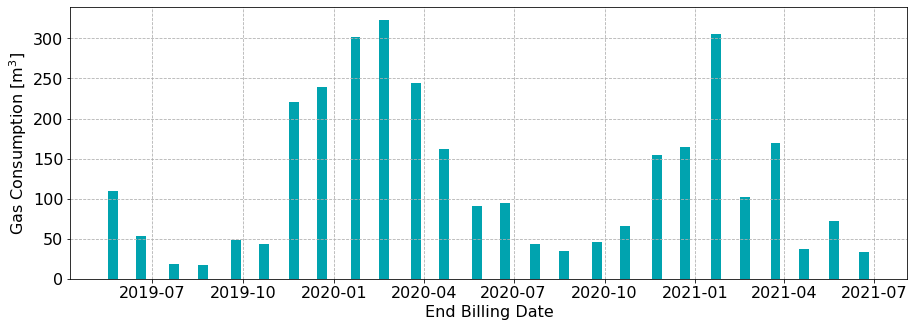

In [83]:
# Initial visualization of gas data
# Recall some bars are high post-retrofit because it is an estimated consumption based on last years data
plt.figure(figsize=(15,5))
plt.bar(gas.To,gas.Consumption,width=10,color = step_blue)
plt.grid(ls='--')
plt.xlabel('End Billing Date')
plt.ylabel('Gas Consumption [m$^{3}$]')

You can see that there appears to be a reduction in gas usage starting in 2021 but still need to weather normalize the data. The 2021 data is also not smooth because some months are estimated, and the estimate is based on previous years data (when there was no ASHP). Estimated vs. actual meter readings for the post-installation period are shown in the data imported above.

,Months,From,To,HighTemp,LowTemp,Off-Peak,Mid-Peak,On-Peak,Total
0,Jan,2019-01-01,2019-02-01,-2,-11,467.16,115.40,173.27,755.83
1,Feb,2019-02-01,2019-03-01,0,-8,418.31,65.45,117.60,601.36
2,Mar,2019-03-01,2019-04-01,3,-5,398.29,98.39,142.84,639.52
3,Apr,2019-04-01,2019-05-01,11,2,290.33,56.66,114.47,461.46
4,May,2019-05-01,2019-06-01,17,7,231.61,44.80,83.18,359.59
5,Jun,2019-06-01,2019-07-01,23,13,192.71,51.52,79.49,323.72
6,Jul,2019-07-01,2019-08-01,29,18,206.15,53.33,87.32,346.80
7,Aug,2019-08-01,2019-09-01,26,16,170.59,46.46,56.57,273.62
8,Sep,2019-09-01,2019-10-01,22,13,343.50,64.15,108.54,516.19
9,Oct,2019-10-01,2019-11-01,15,6,321.72,70.58,154.36,546.66


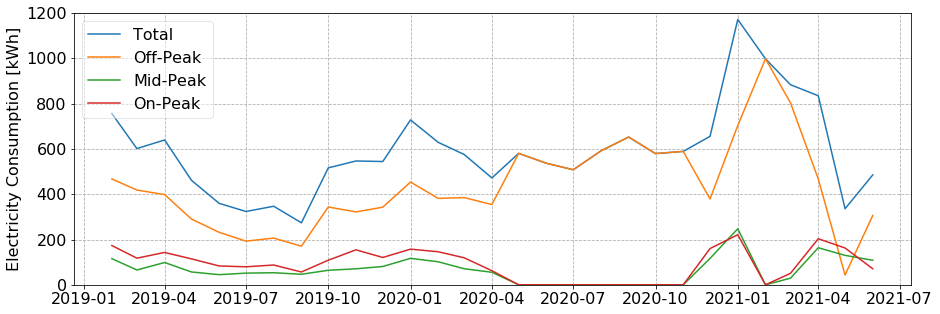

In [84]:
# Import electricity data 
elec2019 = pd.read_csv("Elec_2019.csv",parse_dates=['From','To'])
elec2019['Total'] = elec2019['Off-Peak'] + elec2019['Mid-Peak'] + elec2019['On-Peak']
elec2020 = pd.read_csv("Elec_2020.csv",parse_dates=['From','To'])
elec2020['Total'] = elec2020['Off-Peak'] + elec2020['Mid-Peak'] + elec2020['On-Peak']
elec2021 = pd.read_csv("Elec_2021.csv",parse_dates=['From','To'])
elec2021['Total'] = elec2021['Off-Peak'] + elec2021['Mid-Peak'] + elec2021['On-Peak']
elec = pd.concat([elec2019,elec2020,elec2021])
elec.reset_index(inplace=True)
del elec['index']

# Visualize
plot_cols = ['Total','Off-Peak','Mid-Peak','On-Peak']
plt.figure(figsize=(15,5))
plt.ylabel('Electricity Consumption [kWh]')
plt.grid(ls='--')
plt.ylim(0,1200)
for col in plot_cols:
    plt.plot(elec.To,elec[col],label=col)
plt.legend(loc=2,framealpha=0.5)

# Have a look at the actual data
elec.head(50)

Interestingly the electricity consumption tends to be highest in the winter months during pre-retrofit. Best guess is that it is due to the furnace blower. There is no electric heating at the residence, no hot tub, or other temperature-dependent load aside from the furnace blower. The homeowner must have seldom use A/C in the 2019, but did use it in 2020. Also worth noting is that, due to COVID-19 the electricity is completely off-peak for a portion of 2020 and 2021. There is a spike in electricity consumption for 2021-01. This is believed to be related to an installation issue that was fixed by the contractor related to inadequate cold air return that caused the heat pump to cycle on an off and cut out unexpectedly. This analysis used data after this issue was fixed.

## 4 Import Heating and Cooling Degree Day Data
It is helpful to have a look at weather normalized utility data. We can normalize using HDDs. Weather data for toronto has been gathered from weatherstats.ca which is essentially just a way of accessing Environment Canada data.

In [85]:
# Import hourly weather data file for Toronto and calculate HDDs
toronto_weather = pd.read_csv("weatherstats_toronto_hourly.csv",parse_dates=True, infer_datetime_format=True)
toronto_weather.date_time_local = [datetime.datetime.strptime(x,'%m/%d/%Y %H:%M') for x in toronto_weather.date_time_local]
toronto_weather = toronto_weather[['date_time_local','temperature']]
toronto_weather['HDDs'] = [(16 - x)*(1/24) if (x < 16) else 0 for x in toronto_weather.temperature] 
toronto_weather['CDDs'] = [(x - 24)*(1/24) if (x > 24) else 0 for x in toronto_weather.temperature]
toronto_weather.index = toronto_weather.date_time_local
del toronto_weather['date_time_local']
toronto_weather.head()

,temperature,HDDs,CDDs
date_time_local,,,
2021-07-02 08:00:00,18.0,0.0,0.0
2021-07-02 07:00:00,16.8,0.0,0.0
2021-07-02 06:00:00,16.4,0.0,0.0
2021-07-02 05:00:00,16.4,0.0,0.0
2021-07-02 04:00:00,16.3,0.0,0.0


## 5 Utility Rates and Emission Factors
### 5.1 Natural Gas Rate
The marginal cost of natural gas was estimated using the Ontatio Energy Board (OEB) bill calculator, available at: https://www.oeb.ca/rates-and-your-bill/bill-calculator. Two sample bills were calculated in November 2021 for an Enbridge service area, one for 100 m3 consumption and one for 200 m3. These are shown below. 

![GasBills3.png](GasBills3.png)

The difference in cost between the two bills is 39.3 dollars - for a difference in consumption of 100 m$^{3}$. It follows that the marginal rate for gas was estimated at 0.393 dollars per m3. At the end of 2020 the federal government announced a new cabron pricing schedule in their plan titled "A Healthy Environment and A Healthy Economy." Starting in 2023, the federal price on carbon will increase at 15 dollars per tonne annually to reach 170 dollars by 2030. It will close to double the current rate by 2030. This has significant implications for hybrid systems and it is considered at the end of this notebook.

In [86]:
# Define gas rate
gas_rate = 0.393 # $/m3

### 5.3 Electricity Rate 
The current marginal electricity rates were also calculated using the OEB bill calculator. Six bills were calculated in total. Each bill assumed that electricity was consumed entirely in only one time-of-use (TOU) bracket. For each TOU bracket a 500 kWh and a 600 kWh was calculated. The difference between the two bills was used to calculated the marginal electricity rate for the TOU. This kind of approach was necessary to properly capture all marginal costs, and is helpful because it is straightforward and electricity pricing structures can be complex with mutiple line items. Bills were calculated in November 2021.

The results for peak electricity are shown below - with 500 kWh bill on the left an 600 kWh on the right. The difference between the two bills is dollars 18.8, leading to marginal peak electricity cost estimate of 0.188 dollars per kWh.
![peak_elec.png](peak_elec.png)

The results for mid-peak electricity are shown below - with 500 kWh bill on the left an 600 kWh on the right. The difference between the two bills is 13.1 dollars, leading to marginal peak electricity cost estimate of 0.131 dollars per kWh.
![mid_elec.png](mid_elec.png)

The results for off-peak electricity are shown below - with 500 kWh bill on the left an 600 kWh on the right. The difference between the two bills is 10.1 dollars, leading to marginal peak electricity cost estimate of  0.101 $\$$/kWh.
![off_elec.png](off_elec.png)

Previous analysis (https://sustainabletechnologies.ca/app/uploads/2021/05/DualFuelAnalysis052021.pdf) estimated that 66% of the heating load occurs in an off-peak TOU and the remained is roughly split between mid-peak and on-peak. For simplicity, the analysis looked at the impacts on total electricity consumption only - with the total rate weighted to the percentages above.

In [87]:
# Define elec rates
elec_rate = 0.66*0.101 + 0.131*(0.33/2) + 0.188*(0.33/2)
elec_rate

print("The gas rate is " + str(gas_rate) + ' dollars per cubic meter.')
print("The electricity rate for the heat pump is " + str(elec_rate) + ' dollars per cubic meter.')

The gas rate is 0.393 dollars per cubic meter.
The electricity rate for the heat pump is 0.11929500000000003 dollars per cubic meter.


The emission factors for electricity and natural gas are discussed in the whitepaper linked above. The emission factor for electricity was estimated at 0.030 kg equivalent CO2 per kWh. The emission factor for natural gas combustion was assumed at 1.89 kg equivalent CO2 per cubic metre. Values are from the 2021 Canadian National Inventory Report.

In [88]:
# Define emission factor assumptions
EF_elec = 0.030 # in units kg CO2e per kWh; 
EF_gas = 1.89 # in units kg CO2e per m3

## 6 Calculate HDDs and Define Regression Models of Utility Consumption
We can now add HDDs to the utility consumption dataframes.
### 6.1 Natural Gas

In [89]:
# Function that determines total HDDs in a given window of time
def HDD_total(start_date,end_date):
    temp_df = toronto_weather.loc[(toronto_weather.index>start_date)&(toronto_weather.index<end_date)]
    total_HDDs = temp_df.HDDs.sum()
    total_CDDs = temp_df.CDDs.sum()
    return {'HDDs':total_HDDs,'CDDs':total_CDDs}

# Function that calculates the fraction of time below -5oC
def below_minus5(start_date,end_date):
    temp_df = toronto_weather.loc[(toronto_weather.index>start_date)&(toronto_weather.index<end_date)]
    total_hours = len(temp_df)
    below_m5 = 0
    for temp in temp_df.temperature:
        if temp < -5:
            below_m5 = below_m5 + 1
    return below_m5/total_hours*100
    

In [90]:
# Add HDDs to gas dataframe
gas['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(gas.From,gas.To)]
gas['Below_m5'] = [below_minus5(x,y) for x,y in zip(gas.From,gas.To) ] # How frequently is it below -5oC outside?
gas

,From,To,Consumption,Gas Charge,Gas Charge HST,Invoice Amount,Est_Act,Meter_Reading,HDDs,Below_m5
0,2021-05-22,2021-06-21,33,NaN,NaN,77.55,Actual,38034.0,30.416667,0.000000
1,2021-04-22,2021-05-21,72,45.62,5.93,54.93,Estimated,38001.0,170.479167,0.000000
2,2021-03-24,2021-04-21,37,33.85,4.40,68.75,Actual,37929.0,221.316667,0.000000
3,2021-02-21,2021-03-23,169,72.64,9.44,109.01,Estimated,NaN,448.037500,14.066852
4,2021-01-23,2021-02-20,102,52.84,6.87,86.82,Actual,37723.0,644.012500,71.535022
5,2020-12-22,2021-01-22,305,112.01,14.56,153.68,Estimated,37621.0,510.437500,5.114401
6,2020-11-24,2020-12-21,165,70.25,9.14,220.66,Actual,37316.0,407.687500,11.901082
7,2020-10-23,2020-11-23,155,67.36,8.76,108.09,Estimated,37151.0,277.608333,1.209677
8,2020-09-24,2020-10-22,66,41.06,5.34,143.58,NaN,NaN,111.141667,0.000000
9,2020-08-22,2020-09-23,46,34.69,4.51,64.61,NaN,NaN,38.954167,0.000000


In [91]:
# Create a dataframe for 2-month periods since an actual meter read only happens every other month
# This will reduce scatter when I go to plot the data

end_dates = []
start_dates = []
consumptions = []
hdds = []
below_m5 = []

for ind in gas.index.to_list()[:-1:2]:
    end_dates.append(gas.loc[gas.index == ind].To.to_list()[0])
    start_dates.append(gas.loc[gas.index == (ind+1)].From.to_list()[0])
    consumptions.append(gas.loc[(gas.index == (ind+1))|(gas.index == (ind))].Consumption.sum())
    hdds.append(gas.loc[(gas.index == (ind+1))|(gas.index == (ind))].HDDs.sum())
    below_m5.append((gas.loc[(gas.index == (ind+1))|(gas.index == (ind))].Below_m5.mean()))

# Create dataframe for two month data
gas_2m = pd.DataFrame({
    'From': start_dates,
    'To': end_dates,
    'Consumption':consumptions,
    'HDDs':hdds,    
    'Below_m5': below_m5,
})

gas_2m.head(15)

,From,To,Consumption,HDDs,Below_m5
0,2021-04-22,2021-06-21,105,200.895833,0.000000
1,2021-02-21,2021-04-21,206,669.354167,7.033426
2,2020-12-22,2021-02-20,407,1154.450000,38.324712
3,2020-10-23,2020-12-21,320,685.295833,6.555380
4,2020-08-22,2020-10-22,112,150.095833,0.000000
5,2020-06-23,2020-08-21,78,2.404167,0.000000
6,2020-04-23,2020-06-22,186,235.666667,0.000000
7,2020-02-22,2020-04-22,406,745.058333,5.121294
8,2019-12-21,2020-02-21,625,1055.737500,20.248379
9,2019-10-23,2019-12-20,459,831.850000,11.909239


(0, 700)

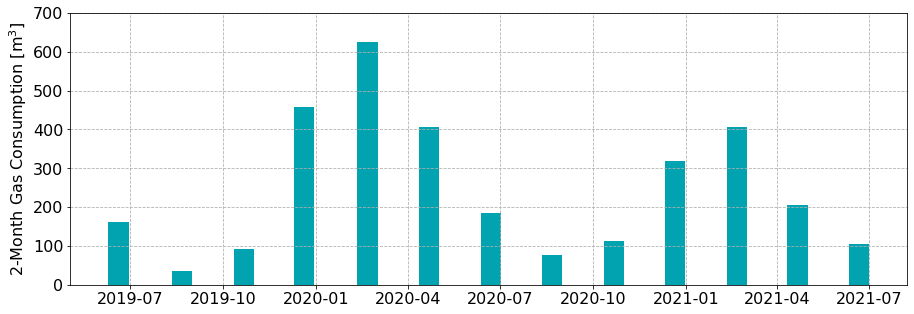

In [92]:
# Visualize it
plt.figure(figsize=(15,5))
plt.bar(gas_2m.To,gas_2m.Consumption,width = 20, color = step_blue)
plt.grid(ls='--')
plt.ylabel('2-Month Gas Consumption [m$^{3}$]')
plt.ylim(0,700)

It's pretty clearly not switching between furnace and heat pump at -5oC. You can see it from the 2-month aggregated data. The switchover must be a higher value. The post-installation period has three 2-month data points. From 2020-12-22 to 2021-02-20 it is below -5 oC 38% percent of the time. But for the next two points it is below minus 7% of the time, and never - yet gas consumption remains somewhat high.

In [93]:
# Create dataframes for pre- and post-install
baseline = gas_2m.loc[(gas_2m.index == 8)|(gas_2m.index == 7)|(gas_2m.index == 6)]
hp_retrofit = gas_2m.loc[(gas_2m.index == 0)|(gas_2m.index == 1)|(gas_2m.index == 2)]

In [94]:
# Look at HDDs during the baseline
baseline.HDDs.sum()

2036.4625

In [95]:
# Look at HDDs during the post-retrofit period
hp_retrofit.HDDs.sum()

2024.6999999999996

In [96]:
# Percentage difference in HDDs.
(baseline.HDDs.sum()/hp_retrofit.HDDs.sum()-1)*100

0.5809502642367015

There is les than 1% difference in HDDs so both periods are comparable in terms of weather. In the next step, I'll define regression models that plot gas consumption as a function of HDDs.

In [97]:
# Calculate regression line for baseline data
x = np.array(baseline.HDDs).reshape((-1, 1))
y = np.array(baseline.Consumption)
base_model_gas = LinearRegression()
base_model_gas.fit(x, y)
base_model_gas_r_sq = base_model_gas.score(x, y)
print('coefficient of determination:', base_model_gas_r_sq)
print('intercept:', base_model_gas.intercept_)
print('slope:', base_model_gas.coef_)

coefficient of determination: 0.9811633394575499
intercept: 49.19051294690456
slope: [0.52514027]


In [98]:
# Calculate regression line post dual-fuel retrofit
x = np.array(hp_retrofit.HDDs).reshape((-1, 1))
y = np.array(hp_retrofit.Consumption)
ret_model_gas = LinearRegression()
ret_model_gas.fit(x, y)
ret_model_gas_r_sq = ret_model_gas.score(x, y)
print('coefficient of determination:', ret_model_gas_r_sq)
print('intercept:', ret_model_gas.intercept_)
print('slope:', ret_model_gas.coef_)

coefficient of determination: 0.9683616965405949
intercept: 25.195945312294327
slope: [0.31728758]


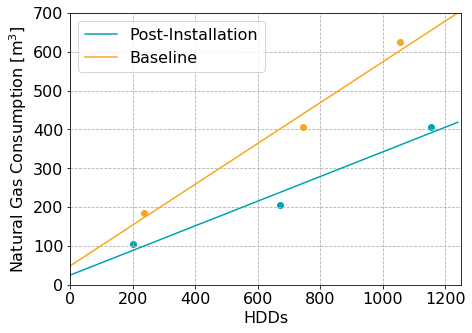

In [99]:
# Create a plot
plt.figure(figsize=(7,5))
plt.ylabel('Natural Gas Consumption [m$^{3}$]')
plt.xlabel('HDDs')

# Plot regression line for post-retrofit data
new_x = np.arange(0,1250,10).reshape((-1,1))
y_pred_ret_gas = ret_model_gas.predict(new_x)
plt.plot(new_x,y_pred_ret_gas,color = step_blue, label = 'Post-Installation')

# Plot regression line for baseline data
new_x = np.arange(0,1250,10).reshape((-1,1))
y_pred_base_gas = base_model_gas.predict(new_x)
plt.plot(new_x,y_pred_base_gas,color = step_gold,label = 'Baseline')

# Plot datapoints
plt.scatter(baseline.HDDs,baseline.Consumption, color=step_gold)
plt.scatter(hp_retrofit.HDDs,hp_retrofit.Consumption, color=step_blue)
plt.xlim(0,1250)
plt.ylim(0,700)
plt.grid(ls='--')
plt.legend()


The data looks reasonable, with gas consumption being a somewehat linear function of HDDs. It is of course not that simple because of the switchover point, so HDDs isn't a perfect independent variable for a model, but it the best available.

Gas consumption 2020 (m3): 1217
Gas consumption 2021 (m3): 718
Gas consumption reduced by (%): 0.410024650780608
Gas consumption reduced by (m3): 499
Gas consumption reduced by ($): 196.107
Gas consumption reduced by (ton): 943.1099999999999


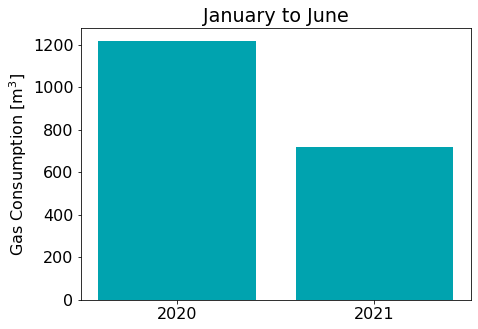

In [100]:
# Can also just plot directly compare the gas bills 
gas_2020 = baseline.Consumption.sum()
gas_2021 = hp_retrofit.Consumption.sum()
pos = [0,1]
plt.figure(figsize=(7,5))
plt.bar(pos,[gas_2020,gas_2021], tick_label=['2020','2021'], color = step_blue)
plt.ylabel('Gas Consumption [m$^{3}$]')
plt.title('January to June')
print('Gas consumption 2020 (m3): ' + str(gas_2020))
print('Gas consumption 2021 (m3): ' + str(gas_2021))
print('Gas consumption reduced by (%): ' + str(-1*(gas_2021/gas_2020-1)))
print('Gas consumption reduced by (m3): ' + str((gas_2020 - gas_2021)))
print('Gas consumption reduced by ($): ' + str((gas_2020 - gas_2021)*gas_rate))
print('Gas consumption reduced by (ton): ' + str((gas_2020 - gas_2021)*EF_gas))

### 6.2 Electricity

In [101]:
# Add HDDs to elec dataframe
elec['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(elec.From,elec.To)]
elec['CDDs'] = [HDD_total(x,y)['CDDs'] for x,y in zip(elec.From,elec.To)]
elec['Year'] = [x.year for x in elec.From]
elec.head(50)


,Months,From,To,HighTemp,LowTemp,Off-Peak,Mid-Peak,On-Peak,Total,HDDs,CDDs,Year
0,Jan,2019-01-01,2019-02-01,-2,-11,467.16,115.40,173.27,755.83,696.829167,0.000000,2019
1,Feb,2019-02-01,2019-03-01,0,-8,418.31,65.45,117.60,601.36,559.804167,0.000000,2019
2,Mar,2019-03-01,2019-04-01,3,-5,398.29,98.39,142.84,639.52,523.904167,0.000000,2019
3,Apr,2019-04-01,2019-05-01,11,2,290.33,56.66,114.47,461.46,292.587500,0.000000,2019
4,May,2019-05-01,2019-06-01,17,7,231.61,44.80,83.18,359.59,142.416667,0.112500,2019
5,Jun,2019-06-01,2019-07-01,23,13,192.71,51.52,79.49,323.72,23.166667,6.600000,2019
6,Jul,2019-07-01,2019-08-01,29,18,206.15,53.33,87.32,346.80,0.329167,39.783333,2019
7,Aug,2019-08-01,2019-09-01,26,16,170.59,46.46,56.57,273.62,2.875000,14.400000,2019
8,Sep,2019-09-01,2019-10-01,22,13,343.50,64.15,108.54,516.19,23.554167,4.387500,2019
9,Oct,2019-10-01,2019-11-01,15,6,321.72,70.58,154.36,546.66,165.229167,1.420833,2019


Elec consumption 2020 (kWh): 2792.93
Elec consumption 2021 (kWh): 3536.84
Elec consumption increased by (%): 0.2663546884454677
Elec consumption increased by (kWh): 743.9100000000003
Elec consumption increased by ($): 88.74474345000006
Elec consumption increased by (ton): 22.31730000000001


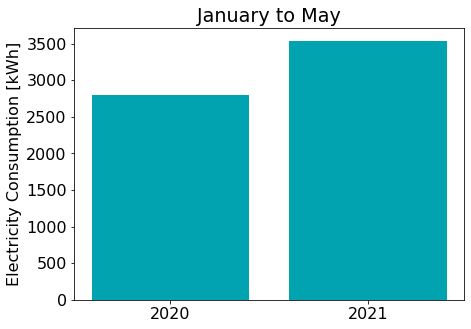

In [102]:
# Compare electricity consumption for in 2020 (pre-install) and 2021 (post-install)
# January to May (rather than June) because I didn't have the electricity data for June when this analysis was done
# The difference in dates does not impact things because the full season was modeled
elec_2020 = elec.loc[(elec.index > 11) & (elec.index < 17)].Total.sum()
elec_2021 = elec.loc[(elec.index > 23)].Total.sum()
pos = [0,1]
plt.figure(figsize=(7,5))
plt.bar(pos,[elec_2020,elec_2021], tick_label=['2020','2021'],color=step_blue)
plt.ylabel('Electricity Consumption [kWh]')
plt.title('January to May')
print('Elec consumption 2020 (kWh): ' + str(elec_2020))
print('Elec consumption 2021 (kWh): ' + str(elec_2021))
print('Elec consumption increased by (%): ' + str((elec_2021/elec_2020-1)))
print('Elec consumption increased by (kWh): ' + str((elec_2021 - elec_2020)))
print('Elec consumption increased by ($): ' + str((elec_2021 - elec_2020)*elec_rate))
print('Elec consumption increased by (ton): ' + str((elec_2021 - elec_2020)*EF_elec))

In [103]:
# Calc baseline electricity consumption
# This is a "model" as well, just a constant one
# Include a correction for the fridge - assumed 1539 kWh/yr based on the Energystar flip your fridge calculator
# Omitted December because the issue with the ASHP was being sorted out 
base_monthly_elec = sum(elec.loc[elec.Year == 2020].Total.to_list()[:-1])/11 - (1539/11) # Correct for fridge in 2020
base_monthly_elec

439.0181818181818

Text(0, 0.5, 'Total Electricity [kWh]')

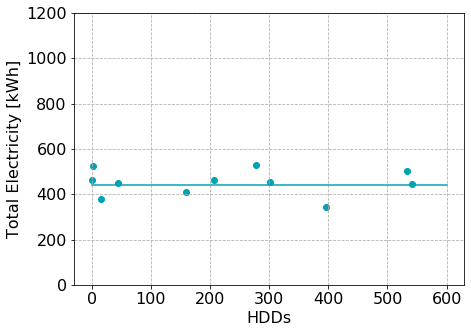

In [104]:
# Plot it
x = [0,600]
y = [base_monthly_elec, base_monthly_elec]
plt.figure(figsize=(7,5))
plt.scatter(elec.loc[elec.Year == 2020].HDDs.to_list()[:-1],(elec.loc[elec.Year == 2020]['Total']-1539/12).to_list()[:-1],color=step_blue) # Again, correcting for fridge
plt.plot(x,y,color=step_blue)
plt.grid(ls='--')
plt.ylim(0,1200)
plt.xlabel('HDDs')
plt.ylabel('Total Electricity [kWh]')

There was an outlier in December 2020. That is due to an installation issue that was rectified in January 2021. I won't consider that data point. Aside from that, monthly electricity consumption is relatively constant. For the calculation we will assume a constant baseline electricity consumption that is the average of the 2020 monthly data.

Let's look at the weather-normalized electricity consumption pre- and post-retrofit.

coefficient of determination: 0.766970742720417
intercept: 237.00428671700223
slope: [1.22371843]


Text(0, 0.5, 'Monthly Electricity')

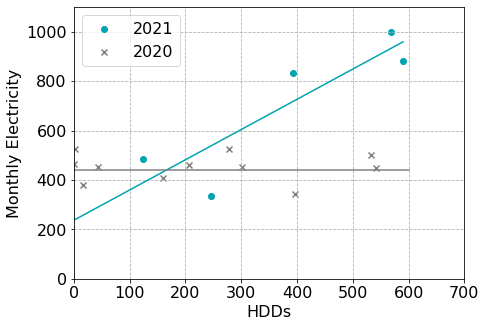

In [105]:
# Grab post-retrofit electricity data from dataframe
elec_post = elec.loc[(elec.Year == 2021)&(elec.index > 0)] #ignore january

# Calculate regression line for the post-install data
x = np.array(elec_post.HDDs).reshape((-1, 1))
y = np.array(elec_post.Total)
model_elec = LinearRegression()
model_elec.fit(x, y)
r_sq = model_elec.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model_elec.intercept_)
print('slope:', model_elec.coef_)

# Plot Regression Line 
plt.figure(figsize=(7,5))
new_x = np.arange(0,600,10).reshape((-1,1))
y_pred = model_elec.predict(new_x)
plt.plot(new_x,y_pred,color = step_blue)
plt.scatter(elec_post.HDDs,elec_post.Total,color = step_blue, label = '2021')
plt.ylim(0,1100)
plt.xlim(0,700)
plt.grid(ls='--')


plt.scatter(elec.loc[elec.Year == 2020].HDDs.to_list()[:-1],(elec.loc[elec.Year == 2020]['Total']-1539/12).to_list()[:-1],color = 'grey', marker='x', label = '2020')
x = [0,600]
y = [base_monthly_elec, base_monthly_elec]
plt.plot(x,y,color='grey')
plt.legend(loc=2)

plt.xlabel('HDDs')
plt.ylabel('Monthly Electricity')


There is a reasonably good model total electricity consumption post-installation. So now there are models for pre- and post-retrofit gas consumption, as well as the same for electricity consumption. They are defined explicitly below. Note that the post-retrofit model should not cross the baseline model. This is corrected for below where the models are defined, but even so, it only impacts September and May which have low HDDs.

In [106]:
# Define models clearly

def pre_gas(HDDs):
    return(base_model_gas.coef_[0] * HDDs + (base_model_gas.intercept_/2)) #Divide by two because the y-intercept includes water-heating and other gas usage from 2-months

def post_gas(HDDs):
    return(ret_model_gas.coef_[0] * HDDs + (ret_model_gas.intercept_/2)) #Divide by two because the y-intercept includes water-heating and other gas usage from 2-months

def pre_elec(HDDs):
    return(base_monthly_elec)

def post_elec(HDDs):
    HDDs = np.array([HDDs]).reshape((-1,1))
    estimate = model_elec.predict(HDDs)[0]
    if estimate > base_monthly_elec:
        return estimate
    else:
        return base_monthly_elec # don't let it go below the baseline value, that would not make sense


## 7 Apply Models to 2020/2021 Heating Season Climate Data 
Since the retrofit was completed in 2021, the previous cost, energy and carbon savings were only for part of a heating season. We want to be able to estimate what they would be for a full heating season and we will use the HDDs from 2020/2021 to do that looking at Septemeber to May.

In [107]:
# Grab heating season HDDs
winter_2020_2021 = elec.loc[elec.index>19][['Months','HDDs']]
winter_2020_2021

,Months,HDDs
20,Sep,43.883333
21,Oct,206.608333
22,Nov,277.258333
23,Dec,503.375000
24,Jan,568.341667
25,Feb,590.391667
26,Mar,392.804167
27,Apr,246.558333
28,May,123.766667


In [108]:
# Calculate baseline vs. post-retofit monthly consumption using models
winter_2020_2021['Base_Elec_kWh'] = [pre_elec(x) for x in winter_2020_2021.HDDs]
winter_2020_2021['Retrofit_Elec_kWh'] = [post_elec(x) for x in winter_2020_2021.HDDs]
winter_2020_2021['Base_Gas_m3'] = [pre_gas(x) for x in winter_2020_2021.HDDs]
winter_2020_2021['Retrofit_Gas_m3'] = [post_gas(x) for x in winter_2020_2021.HDDs]
winter_2020_2021

,Months,HDDs,Base_Elec_kWh,Retrofit_Elec_kWh,Base_Gas_m3,Retrofit_Gas_m3
20,Sep,43.883333,439.018182,439.018182,47.640162,26.521609
21,Oct,206.608333,439.018182,489.834713,133.093612,78.152231
22,Nov,277.258333,439.018182,576.290420,170.194772,100.568598
23,Dec,503.375000,439.018182,852.993553,288.937738,172.312608
24,Jan,568.341667,439.018182,932.494460,323.054351,192.925725
25,Feb,590.391667,439.018182,959.477452,334.633694,199.921916
26,Mar,392.804167,439.018182,717.685986,230.872541,137.229856
27,Apr,246.558333,439.018182,538.722264,154.072965,90.827870
28,May,123.766667,439.018182,439.018182,89.590117,51.867599


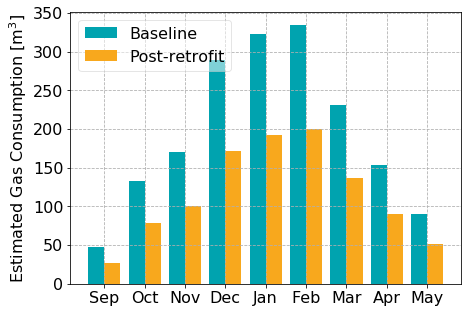

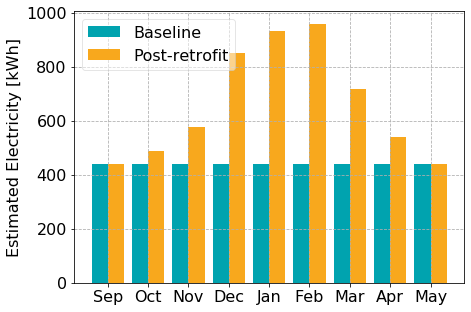

In [109]:
# Visualize modeled monthly results
pos = np.arange(0,9,1)
plt.figure(figsize = (7,5))
plt.bar(pos,winter_2020_2021.Base_Gas_m3,width = -0.4, align = 'edge', tick_label=winter_2020_2021.Months, color = step_blue, label = 'Baseline')
plt.bar(pos,winter_2020_2021.Retrofit_Gas_m3,width = 0.4, align = 'edge', color = step_gold, label = 'Post-retrofit')
plt.grid(ls='--')
plt.ylabel('Estimated Gas Consumption [m$^{3}$]')
plt.legend(loc=2,framealpha=0.5)
plt.show()

plt.figure(figsize = (7,5))
plt.bar(pos,winter_2020_2021.Base_Elec_kWh,width = -0.4, align = 'edge', tick_label=winter_2020_2021.Months, color = step_blue, label = 'Baseline')
plt.bar(pos,winter_2020_2021.Retrofit_Elec_kWh,width = 0.4, align = 'edge', color = step_gold, label = 'Post-retrofit')
plt.grid(ls='--')
plt.ylabel('Estimated Electricity [kWh]')
plt.legend(loc=2,framealpha=0.5)
plt.show()


In [110]:
# Calculate total electricity and gas bill for baseline and post-retrofit
pre_gas_tot = winter_2020_2021.Base_Gas_m3.sum()
post_gas_tot = winter_2020_2021.Retrofit_Gas_m3.sum()
pre_elec_tot = winter_2020_2021.Base_Elec_kWh.sum()
post_elec_tot = winter_2020_2021.Retrofit_Elec_kWh.sum()

In [111]:
pre_gas_tot

1772.089952710751

In [112]:
post_gas_tot

1050.3280127714943

In [113]:
gas_savings = pre_gas_tot - post_gas_tot
gas_savings

721.7619399392568

In [114]:
pre_elec_tot

3951.163636363636

In [115]:
post_elec_tot

5945.535210768504

In [116]:
# Also want to estimate portion of gas consumption that is space heating, and portion that is hot water
gas['End_Month'] = [x.month for x in gas.To] # Add month to gas dataframe
gas.loc[(gas.End_Month == 7)|(gas.End_Month == 8)] # Ending in July or August

,From,To,Consumption,Gas Charge,Gas Charge HST,Invoice Amount,Est_Act,Meter_Reading,HDDs,Below_m5,End_Month
10,2020-07-24,2020-08-21,35,31.56,4.37,-1.70,NaN,NaN,1.841667,0.0,8
11,2020-06-23,2020-07-23,43,33.83,4.72,221.58,NaN,NaN,0.562500,0.0,7
22,2019-07-24,2019-08-22,17,26.07,3.39,147.18,NaN,NaN,0.591667,0.0,8
23,2019-06-21,2019-07-23,18,25.55,3.32,117.72,NaN,NaN,1.404167,0.0,7


In [117]:
# Use most recent data
DHW_monthly = (35 + 43)/2

In [118]:
pre_gas_DHW = DHW_monthly*9
pre_gas_DHW

351.0

In [119]:
pre_gas_SH = pre_gas_tot - pre_gas_DHW
pre_gas_SH

1421.089952710751

In [120]:
post_gas_DHW = pre_gas_DHW # ie. no DHW change
post_gas_SH = post_gas_tot - post_gas_DHW
post_gas_SH

699.3280127714943

In [121]:
# Percentage gas savings for heating
(1 - post_gas_SH/pre_gas_SH)*100

50.78932115187252

In [122]:
elec_increase = post_elec_tot - pre_elec_tot # increase electricity due to hybrid system
elec_increase

1994.3715744048677

In [123]:
gas_savings*gas_rate

283.6524423961279

In [124]:
elec_increase*elec_rate

237.91855696862874

In [125]:
net_cost_savings = gas_savings*gas_rate - elec_increase*elec_rate 
net_cost_savings

45.73388542749919

Gas savings (%): 40.72941888955375
Gas savings (m3): 721.7619399392568
Gas savings ($): 283.6524423961279
Gas savings (kgCO2): 1364.1300664851951


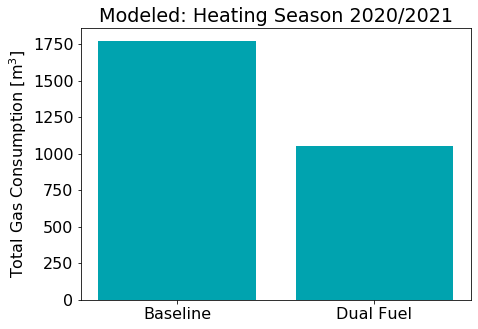

In [126]:
# Visualize gas results
pos = [0,1]
plt.figure(figsize = (7,5))
plt.bar(pos,[pre_gas_tot,post_gas_tot], tick_label = ['Baseline','Dual Fuel'],color = step_blue)
plt.ylabel('Total Gas Consumption [m$^{3}$]')
plt.title('Modeled: Heating Season 2020/2021')

# Print gas results
print('Gas savings (%): ' + str(-1*(post_gas_tot/pre_gas_tot-1)*100))
print('Gas savings (m3): ' + str(gas_savings))
print('Gas savings ($): ' + str((gas_savings)*gas_rate))
print('Gas savings (kgCO2): ' + str((gas_savings)*EF_gas))

Elec increase (%): 50.475549938001116
Elec increase (kWh): 1994.3715744048677
Elec increase ($): 237.91855696862874
Elec increase (kgCO2): 59.83114723214603


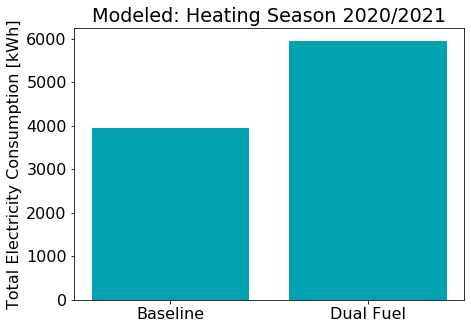

In [127]:
# Visualize elec results
pos = [0,1]
plt.figure(figsize = (7,5))
plt.bar(pos,[pre_elec_tot,post_elec_tot], tick_label = ['Baseline','Dual Fuel'],color = step_blue)
plt.ylabel('Total Electricity Consumption [kWh]')
plt.title('Modeled: Heating Season 2020/2021')

# Print gas results
print('Elec increase (%): ' + str((post_elec_tot/pre_elec_tot-1)*100))
print('Elec increase (kWh): ' + str(elec_increase))
print('Elec increase ($): ' + str((elec_increase)*elec_rate))
print('Elec increase (kgCO2): ' + str((elec_increase)*EF_elec))

In [128]:
# Total cost and carbon results
print('Total carbon savings (kgCO2): ' + str((pre_gas_tot - post_gas_tot)*EF_gas-(post_elec_tot - pre_elec_tot)*EF_elec))
pre_carb_kg = pre_gas_tot*EF_gas+pre_elec_tot*EF_elec
post_carb_kg = post_gas_tot*EF_gas+post_elec_tot*EF_elec
carb_save_perc = 1-post_carb_kg/pre_carb_kg
print('Total carbon savings (%): ' + str(carb_save_perc))
pre_cost = pre_gas_tot*gas_rate + pre_elec_tot*elec_rate
post_cost = post_gas_tot*gas_rate + post_elec_tot*elec_rate
print('Total cost savings ($): ' + str(pre_cost-post_cost))

Total carbon savings (kgCO2): 1304.298919253049
Total carbon savings (%): 0.3761187471109174
Total cost savings ($): 45.73388542749922


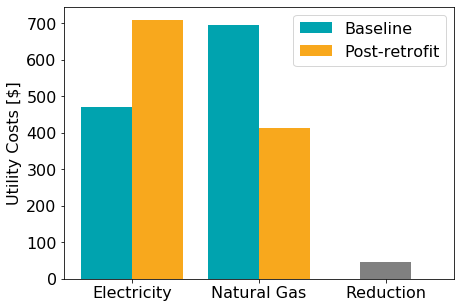

In [129]:
# Put the costs in the same plot
# Note does not include fixed costs for maintaining an account with the utility
plt.figure(figsize=(7,5))
plt.bar([0,1,2],[pre_elec_tot*elec_rate,pre_gas_tot*gas_rate,0], align = 'edge', width = -0.4, color = step_blue, label = 'Baseline')
plt.bar([0,1,2],[post_elec_tot*elec_rate,post_gas_tot*gas_rate,0], align = 'edge', width = 0.4, color = step_gold, label = 'Post-retrofit')
plt.bar([0,1,2],[0,0,(pre_cost-post_cost)],align = 'center', width = 0.4, color = 'grey', tick_label=['Electricity','Natural Gas','Reduction'])
plt.ylabel('Utility Costs [$]')
plt.legend(loc=0)
plt.savefig('comparison.png')


## 8 Calculation Check

To check if the gas savings is reasonable compared to the electricity incease, it possible to make a calculation to estimate the as-installed COP. This can be compared against a temperature-weighted COP based on manufacturer data. The as-installed number should be lower due to real-world factors like cycling and defrost. Manufacturer data is below.   

![ManufacturerData.png](ManufacturerData.png)

In [130]:
# Import 2-ton HP data
two_ton_HP = pd.read_csv("HP2tonPerformance.csv") 

# Add column for temperature in Celsius
two_ton_HP['Temp_C'] = [(x-32)*5/9 for x in two_ton_HP.Temp_F]

# Create a COP average column for high and low stage
two_ton_HP['COP_ave'] = (two_ton_HP.COP_Low_Stage + two_ton_HP.COP_High_Stage)/2

# Have a look at data 
two_ton_HP.head(20)

,Temp_F,COP_Low_Stage,COP_High_Stage,Cap_Low_Stage_kBtu_hr,Cap_High_Stage_kBtu_hr,Temp_C,COP_ave
0,65,6.02,4.96,21.21,28.42,18.333333,5.490
1,60,5.75,4.70,19.75,26.68,15.555556,5.225
2,55,5.48,4.44,18.32,24.97,12.777778,4.960
3,50,5.19,4.17,16.91,23.29,10.000000,4.680
4,47,4.99,4.00,16.02,22.20,8.333333,4.495
5,45,4.83,3.87,15.33,21.41,7.222222,4.350
6,40,4.41,3.55,13.61,19.43,4.444444,3.980
7,35,4.02,3.23,12.04,17.56,1.666667,3.625
8,30,3.70,2.98,10.77,16.03,-1.111111,3.340
9,25,3.48,2.80,9.82,14.91,-3.888889,3.140


coefficient of determination: 0.9939251936048709
intercept: 3.6258298493334387
slope: [0.10044645]


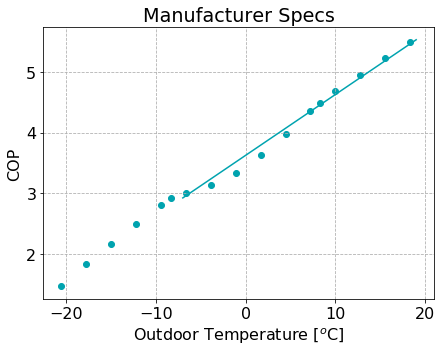

In [131]:
# Manufacturer COP data 
COP_Temps_C = two_ton_HP.Temp_C
COPs = two_ton_HP.COP_ave

# Visulualize COP data
plt.figure(figsize = (7,5))
plt.scatter(COP_Temps_C, COPs, color = step_blue)
plt.xlabel('Outdoor Temperature [$^{o}$C]')
plt.ylabel('COP')

# Calculate regression model for COP
x = np.array(COP_Temps_C).reshape((-1, 1))
y = np.array(COPs)
COP_model = LinearRegression()
COP_model.fit(x, y)
COP_model_r_sq = COP_model.score(x, y)
print('coefficient of determination:', COP_model_r_sq)
print('intercept:', COP_model.intercept_)
print('slope:', COP_model.coef_)

# Define COP Function
def COP_func(Temp):
    COP = COP_model.coef_[0] * Temp + COP_model.intercept_
    return COP

# Plot model
x = np.arange(-7,20,1)
y = [COP_func(a) for a in x]
plt.plot(x,y, color = step_blue)    
plt.title('Manufacturer Specs')
plt.grid(ls='--')

In [132]:
# Calculate temperature-weighted COP for post-retrofit period
start = datetime.datetime.strptime('09/01/2020','%m/%d/%Y')
stop = datetime.datetime.strptime('05/31/2021','%m/%d/%Y')
post_weather_hp = toronto_weather.loc[(toronto_weather.index > start)&
                                   (toronto_weather.index < stop)&
                                   (toronto_weather.temperature < 16)&
                                   (toronto_weather.temperature > -1)] # only operated above -1oC
post_weather_hp['COP'] = [COP_func(x) for x in post_weather_hp.temperature]
temp_weighted_COP = post_weather_hp.COP.mean()
temp_weighted_COP

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


4.292687389786281

A temperature-weight COP is not perfect though because more heat Energy is supplied at colder temperatures. That means that colder temperatures should actually be weighted MORE. To get a better estimate of COP this needs to be taken into account.
It's possible to get a better COP estimate by considering a linear building load that is near in scale to the load of this home. 

-0.7952
11.132800000000001


Text(0, 0.5, 'Building Load [kBTU/hr]')

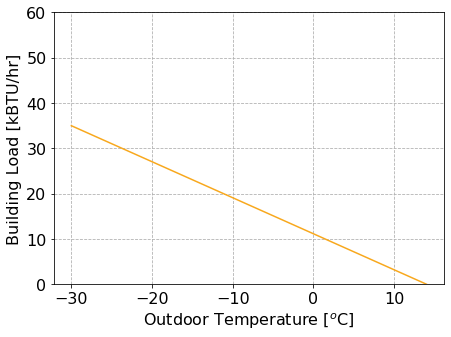

In [133]:
# Assume building load curve is 0 at 14 oC, and equivalent to the heat pump capacity at -4oC (apply a 20% derate)
# Based on the gas savings I think it is near -1 oC or -2oC
# Because of the control we don't know exactly when the heat pump stopped havig enough capacity
# This is just a high-level check on the results so it's fine
x1 = -1
x2 = 14
y1 = 14.91 * 0.80 # heat pump capacity is 16.03 kBTU at 25 F (-3.9 oC) - derate it by 20% as an assumption
y2 = 0

# Slope of linear model
m = (y1 - y2)/(x1 - x2)
print(m)

# Intercept
b = y1 - m * (x1)
print(b)

# Define model
def building_load(temp):
    if temp > 16:
        load = 0
    else:
        load = m * temp + b
    return load

# Visualize
temps_C_even = np.arange(-30,15,1)
load_curve = [building_load(x) for x in temps_C_even]
plt.figure(figsize=(7,5))
plt.plot(temps_C_even,load_curve, color = step_gold, label = 'Building Load')
plt.ylim(0,60)
plt.grid(ls='--')
plt.xlabel('Outdoor Temperature [$^{o}$C]')
plt.ylabel('Building Load [kBTU/hr]')

Use this building load, the COP model, and the temperature data to estimate what the impacts would be for a simple linear building like above. Results should be somewhat close to the real results.

In [134]:
# Timeframe
start = datetime.datetime.strptime('09/01/2020','%m/%d/%Y')
stop = datetime.datetime.strptime('05/31/2021','%m/%d/%Y')
post_weather2 = toronto_weather.loc[(toronto_weather.index > start)&
                                   (toronto_weather.index < stop)].copy()

# Parameters
gas_dens = 10.6 #kWh/m3

# Look-up table for day of week
week_day_dict = {
    0:'Mon',
    1:'Tue',
    2:'Wed',
    3:'Thu',
    4:'Fri',
    5:'Sat',
    6:'Sun',
}

# Define a function that takes a datetime variable, and day of week and determines which TOU it is in
def TOU_find(date_time,day_of_week):
    TOU = 'null'
    if (date_time.hour < 7) | (date_time.hour >= 19) | (day_of_week  == 'Sat') | (day_of_week == 'Sun'):
        TOU = 'off'
    elif (date_time.hour >= 11) & (date_time.hour < 17):
        TOU = 'mid'
    else:
        TOU = 'peak'
    return TOU

# TOU rates look-up table
elec_cost = {
    'off': 0.101,
    'mid': 0.131,
    'peak':0.188,
}

# Function to calculate impacts
def impacts_calc(temp_data_df, switch_temp = -6, furnace_eff = 0.95, HP_derate = 0.20, furnace_eff_pre = 0.85): 
                 
    temp_data_df['Day'] = [week_day_dict[x.weekday()] for x in temp_data_df.index]
    temp_data_df['TOU'] = [TOU_find(x,y) for x,y in zip(temp_data_df.index, temp_data_df.Day)]
    temp_data_df['Elec_rate'] = [elec_cost[x] for x in temp_data_df.TOU]
    temp_data_df['heat_load_kBtu_hr'] = [building_load(x) for x in temp_data_df.temperature]
    temp_data_df['heat_load_kW'] = temp_data_df.heat_load_kBtu_hr / 3.41
    temp_data_df['HP_or_Furnace'] = ['Furnace' if (x < switch_temp) else 'HeatPump' for x in temp_data_df.temperature]
    temp_data_df['Furnace_Delivered_kWh'] = [x if (y == 'Furnace') else 0 for x,y in zip(temp_data_df.heat_load_kW,temp_data_df.HP_or_Furnace)]
    temp_data_df['HP_Delivered_kWh'] = [x if (y == 'HeatPump') else 0 for x,y in zip(temp_data_df.heat_load_kW,temp_data_df.HP_or_Furnace)]
    temp_data_df['Furnace_Consumed_kWh'] = temp_data_df.Furnace_Delivered_kWh/furnace_eff
    temp_data_df['Furnace_Consumed_m3'] = temp_data_df.Furnace_Consumed_kWh/gas_dens
    temp_data_df['Gas_Cost'] = temp_data_df.Furnace_Consumed_m3 * gas_rate
    temp_data_df['HP_COP'] = [COP_func(x)*(1-HP_derate) for x in temp_data_df.temperature]
    temp_data_df['HP_Consumed_kWh'] = temp_data_df.HP_Delivered_kWh/temp_data_df.HP_COP
    temp_data_df['Elec_Cost'] = temp_data_df.HP_Consumed_kWh * temp_data_df.Elec_rate
    temp_data_df['Full_Gas_Consumed_m3'] = temp_data_df.heat_load_kW * (1/furnace_eff_pre) * (1/gas_dens)
    temp_data_df['Full_Gas_Cost'] = temp_data_df.Full_Gas_Consumed_m3 * gas_rate
    
    # Summarize results
    result_dict = {
        'Furnace_Only_m3':temp_data_df.Full_Gas_Consumed_m3.sum(), # Gas consumption if only the furnace was used
        'Furnace_Only_Cost':temp_data_df.Full_Gas_Cost.sum(),  # Gas cost is only the furnace was used
        'Furnace_Only_Delivered_kWh':temp_data_df.heat_load_kW.sum(), # Heat energy required by the home (in kWh)
        'Hyb_Elec_kWh':temp_data_df.HP_Consumed_kWh.sum(),  # Electricity consumed by the heat pump in hybrid system
        'Hyb_HP_Delivered_kWh':temp_data_df.HP_Delivered_kWh.sum(),  # Heat energy delivered by the heat pump in hybrid system
        'Hyb_Gas_m3':temp_data_df.Furnace_Consumed_m3.sum(),   # Natural gas consumption of furnace in hybrid system
        'Hyb_Gas_Delivered_kWh':temp_data_df.Furnace_Delivered_kWh.sum(), # Heat energy delivered by furnace in hybrid system
        'Hyb_Elec_Cost':temp_data_df.Elec_Cost.sum(),  # Electricity cost of hybrid system
        'Hyb_Gas_Cost':temp_data_df.Gas_Cost.sum(),  # Gas cost of hybrid system
        'Hyb_Total_Cost':temp_data_df.Elec_Cost.sum()+temp_data_df.Gas_Cost.sum(), # Total cost of hybrid system
        'ASHP_COP_Ave':temp_data_df.HP_Delivered_kWh.sum()/temp_data_df.HP_Consumed_kWh.sum(), # Average COP of heat pump
        'Gas_Savings_m3':temp_data_df.Full_Gas_Consumed_m3.sum()-temp_data_df.Furnace_Consumed_m3.sum(),  # Gas reduction from hybrid in m3
        'Cost_Savings':temp_data_df.Full_Gas_Cost.sum()-(temp_data_df.Elec_Cost.sum()+temp_data_df.Gas_Cost.sum()), # Cost reduction in hybrid
        'Gas_Savings_Perc':(1-temp_data_df.Furnace_Consumed_m3.sum()/temp_data_df.Full_Gas_Consumed_m3.sum())*100, # Gas savings percent
        'Cost_Savings_Perc':(1-(temp_data_df.Elec_Cost.sum()+temp_data_df.Gas_Cost.sum())/temp_data_df.Full_Gas_Cost.sum())*100, # Cost savings percent
        'df':temp_data_df # Dataframe with full results
    }
    
    return result_dict                 

In [135]:
# Firstly - we can check how well the linear building load matches reality by checking it's predictions for the 
# the preretrofit period against reality. Recall the pre-retrofit data:
baseline

,From,To,Consumption,HDDs,Below_m5
6,2020-04-23,2020-06-22,186,235.666667,0.000000
7,2020-02-22,2020-04-22,406,745.058333,5.121294
8,2019-12-21,2020-02-21,625,1055.737500,20.248379


In [136]:
# Our building load model should predict this for the same time period
baseline.Consumption.sum() - (6 * DHW_monthly)

983.0

In [137]:
# Timeframe
start = datetime.datetime.strptime('12/21/2019','%m/%d/%Y')
stop = datetime.datetime.strptime('06/22/2020','%m/%d/%Y')
post_weather_load_calc = toronto_weather.loc[(toronto_weather.index > start)&
                                   (toronto_weather.index < stop)].copy()

In [138]:
# Use impacts_calc_function to estimate total gas consumption with the current linear building load model
impacts_calc(post_weather_load_calc,furnace_eff_pre = 0.85)['Furnace_Only_m3']

1111.394757861093

-0.70574
9.88036


Text(0, 0.5, 'Building Load [kBTU/hr]')

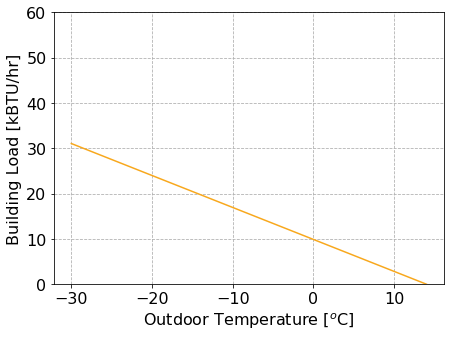

In [148]:
# It's a bit high - redefine building load
x1 = -1
x2 = 14
y1 = 14.91 * 0.71 # heat pump capacity is 16.03 kBTU at 25 F (-3.9 oC) - derate it by 20% as an assumption
y2 = 0

# Slope of linear model
m = (y1 - y2)/(x1 - x2)
print(m)

# Intercept
b = y1 - m * (x1)
print(b)

# Define model
def building_load(temp):
    if temp > 16:
        load = 0
    else:
        load = m * temp + b
    return load

# Visualize
temps_C_even = np.arange(-30,15,1)
load_curve = [building_load(x) for x in temps_C_even]
plt.figure(figsize=(7,5))
plt.plot(temps_C_even,load_curve, color = step_gold, label = 'Building Load')
plt.ylim(0,60)
plt.grid(ls='--')
plt.xlabel('Outdoor Temperature [$^{o}$C]')
plt.ylabel('Building Load [kBTU/hr]')

In [149]:
# Use impacts_calc_function to estimate total gas consumption with the current linear building load model
impacts_calc(post_weather_load_calc,furnace_eff_pre = 0.85)['Furnace_Only_m3']

986.3628476017199

Now the actual gas consumption is close to the predicted value based on the linear building load - so the model has been calibrated.

In [151]:
# Impacts assuming no heat pump derate
impacts_calc(post_weather2,HP_derate=0, furnace_eff_pre = 0.85, switch_temp = -1)

{'Furnace_Only_m3': 1369.7936055409273,
 'Furnace_Only_Cost': 538.3288869775844,
 'Furnace_Only_Delivered_kWh': 12341.840385923753,
 'Hyb_Elec_kWh': 1606.1750235155243,
 'Hyb_HP_Delivered_kWh': 6334.792607038123,
 'Hyb_Gas_m3': 596.5290743679872,
 'Hyb_Gas_Delivered_kWh': 6007.04777888563,
 'Hyb_Elec_Cost': 194.98006643023786,
 'Hyb_Gas_Cost': 234.43592622661896,
 'Hyb_Total_Cost': 429.4159926568568,
 'ASHP_COP_Ave': 3.94402385436975,
 'Gas_Savings_m3': 773.2645311729401,
 'Cost_Savings': 108.91289432072756,
 'Gas_Savings_Perc': 56.45117104102558,
 'Cost_Savings_Perc': 20.231664500155755,
 'df':                      temperature      HDDs      CDDs  Day   TOU  Elec_rate  \
 date_time_local                                                              
 2021-05-30 23:00:00         12.7  0.137500  0.000000  Sun   off      0.101   
 2021-05-30 22:00:00         13.6  0.100000  0.000000  Sun   off      0.101   
 2021-05-30 21:00:00         14.0  0.083333  0.000000  Sun   off      0.101   
 20

The COP should be lower than 3.94 due to real-world factors like cycling and defrost. 

In [152]:
# Impacts assuming 20% heat pump derate
impacts_calc(post_weather2,HP_derate=0.20, furnace_eff_pre = 0.85, switch_temp = -1)

{'Furnace_Only_m3': 1369.7936055409273,
 'Furnace_Only_Cost': 538.3288869775844,
 'Furnace_Only_Delivered_kWh': 12341.840385923753,
 'Hyb_Elec_kWh': 2007.7187793944054,
 'Hyb_HP_Delivered_kWh': 6334.792607038123,
 'Hyb_Gas_m3': 596.5290743679872,
 'Hyb_Gas_Delivered_kWh': 6007.04777888563,
 'Hyb_Elec_Cost': 243.72508303779733,
 'Hyb_Gas_Cost': 234.43592622661896,
 'Hyb_Total_Cost': 478.1610092644163,
 'ASHP_COP_Ave': 3.1552190834958003,
 'Gas_Savings_m3': 773.2645311729401,
 'Cost_Savings': 60.16787771316808,
 'Gas_Savings_Perc': 56.45117104102558,
 'Cost_Savings_Perc': 11.176787864938298,
 'df':                      temperature      HDDs      CDDs  Day   TOU  Elec_rate  \
 date_time_local                                                              
 2021-05-30 23:00:00         12.7  0.137500  0.000000  Sun   off      0.101   
 2021-05-30 22:00:00         13.6  0.100000  0.000000  Sun   off      0.101   
 2021-05-30 21:00:00         14.0  0.083333  0.000000  Sun   off      0.101   
 2

In [154]:
# Impacts assuming 20% heat pump derate and comparing against a base case assuming a higher efficiency furnace as back-up
impacts_calc(post_weather2,HP_derate=0.20, furnace_eff_pre = 0.95, switch_temp = -1)

{'Furnace_Only_m3': 1225.6048049576716,
 'Furnace_Only_Cost': 481.6626883483649,
 'Furnace_Only_Delivered_kWh': 12341.840385923753,
 'Hyb_Elec_kWh': 2007.7187793944054,
 'Hyb_HP_Delivered_kWh': 6334.792607038123,
 'Hyb_Gas_m3': 596.5290743679872,
 'Hyb_Gas_Delivered_kWh': 6007.04777888563,
 'Hyb_Elec_Cost': 243.72508303779733,
 'Hyb_Gas_Cost': 234.43592622661896,
 'Hyb_Total_Cost': 478.1610092644163,
 'ASHP_COP_Ave': 3.1552190834958003,
 'Gas_Savings_m3': 629.0757305896844,
 'Cost_Savings': 3.501679083948602,
 'Gas_Savings_Perc': 51.3277793987933,
 'Cost_Savings_Perc': 0.726998201989848,
 'df':                      temperature      HDDs      CDDs  Day   TOU  Elec_rate  \
 date_time_local                                                              
 2021-05-30 23:00:00         12.7  0.137500  0.000000  Sun   off      0.101   
 2021-05-30 22:00:00         13.6  0.100000  0.000000  Sun   off      0.101   
 2021-05-30 21:00:00         14.0  0.083333  0.000000  Sun   off      0.101   
 202

In [155]:
# Compare that to a COP estimated from the gas savings and electricity increase
# The gas savings times the previous furnace efficiency (estimated 85%) times 10.6 kWh/m3 (energy density for gas) is the estimated
# heat delivered by the heat pump. Some of the savings may be air-sealing - but it is likley small.

as_installed_COP = (gas_savings*0.85*10.6)/elec_increase
as_installed_COP

3.2607138821627353

It looks like the actual COP (based on the gas savings and electricity consumption attributed to the heat pump) is near the expected results if the heat pump is operating at 20% below its manufacturer COP curve, and had -1 oC switchover. This is very reasonable. The heat pump is about breaking even on costs - and the small amount of cost savings is due to the upgrade in efficiency of the furnace from the pre-retofit level. This calculation is not exact, but they do show that the gas and cost reduction are inline with expected results.

## 9 Annual Utility Costs to 2030

At the end of 2020 the federal government announced a new carbon pricing schedule in their plan titled "A Healthy Environment and A Healthy Economy." Starting in 2023, the federal price on carbon will increase at 15$\$$ per year to reach $\$$170 by 2030. This has significant implications for dual fuel heat pump systems. This is outlined in the dataframe below. It ignores other fluctuations in the cost of natural gas and simply adds additional charges onto the current rate.

In [62]:
# Import carbon charge data
# You can see this aligns with carbon charge data from enbridge
# https://www.enbridgegas.com/residential/my-account/rates/federal-carbon-charge (below)
nat_gas_rate_df = pd.read_csv("nat_gas_carbon_pricing.csv")
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3)
0,2021,40,0.078300
1,2022,50,0.097875
2,2023,65,0.127238
3,2024,80,0.156600
4,2025,95,0.185963
5,2026,110,0.215325
6,2027,125,0.244688
7,2028,140,0.274050
8,2029,155,0.303412
9,2030,170,0.332775


![Enbridge_CC2.png](Enbridge_CC2.png)

In [63]:
# Add cost escalation due to carbon charge
gas_rate_no_carbon_charge = gas_rate - 0.078
nat_gas_rate_df['Gas_Rate'] = [gas_rate_no_carbon_charge + x for x in nat_gas_rate_df['Carbon Charge Natural Gas ($/m3)']]
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate
0,2021,40,0.078300,0.393300
1,2022,50,0.097875,0.412875
2,2023,65,0.127238,0.442238
3,2024,80,0.156600,0.471600
4,2025,95,0.185963,0.500962
5,2026,110,0.215325,0.530325
6,2027,125,0.244688,0.559688
7,2028,140,0.274050,0.589050
8,2029,155,0.303412,0.618413
9,2030,170,0.332775,0.647775


In [64]:
# Add electricity cost escalation - 
# Assume 2% per year there has been no recent long-term energy plan to for a better estimate
# Just add it to natural gas data frame
nat_gas_rate_df['Elec_Rate'] = [elec_rate*(1.02)**x for x in nat_gas_rate_df.index]
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Elec_Rate
0,2021,40,0.078300,0.393300,0.119295
1,2022,50,0.097875,0.412875,0.121681
2,2023,65,0.127238,0.442238,0.124115
3,2024,80,0.156600,0.471600,0.126597
4,2025,95,0.185963,0.500962,0.129129
5,2026,110,0.215325,0.530325,0.131711
6,2027,125,0.244688,0.559688,0.134346
7,2028,140,0.274050,0.589050,0.137032
8,2029,155,0.303412,0.618413,0.139773
9,2030,170,0.332775,0.647775,0.142569


In [65]:
# Add utility costs
nat_gas_rate_df['Annual_Gas_Savings'] = [gas_savings*x for x in nat_gas_rate_df.Gas_Rate]
nat_gas_rate_df['Annual_Elec_Increase'] = [elec_increase*x for x in nat_gas_rate_df.Elec_Rate]
nat_gas_rate_df['Annual_Net_Cost_Change'] = [y - x for x,y in zip(nat_gas_rate_df.Annual_Gas_Savings,nat_gas_rate_df.Annual_Elec_Increase)]
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Elec_Rate,Annual_Gas_Savings,Annual_Elec_Increase,Annual_Net_Cost_Change
0,2021,40,0.078300,0.393300,0.119295,283.868971,237.918557,-45.950414
1,2022,50,0.097875,0.412875,0.121681,297.997461,242.676928,-55.320533
2,2023,65,0.127238,0.442238,0.124115,319.190196,247.530467,-71.659729
3,2024,80,0.156600,0.471600,0.126597,340.382931,252.481076,-87.901855
4,2025,95,0.185963,0.500962,0.129129,361.575666,257.530698,-104.044968
5,2026,110,0.215325,0.530325,0.131711,382.768401,262.681311,-120.087089
6,2027,125,0.244688,0.559688,0.134346,403.961136,267.934938,-136.026198
7,2028,140,0.274050,0.589050,0.137032,425.153871,273.293636,-151.860234
8,2029,155,0.303412,0.618413,0.139773,446.346606,278.759509,-167.587096
9,2030,170,0.332775,0.647775,0.142569,467.539341,284.334699,-183.204641


In [66]:
# Total net cost to 2030
nat_gas_rate_df.Annual_Net_Cost_Change.sum()

-1123.642758695965

Text(0, 0.5, 'Net Annual Utility Cost Change [$]')

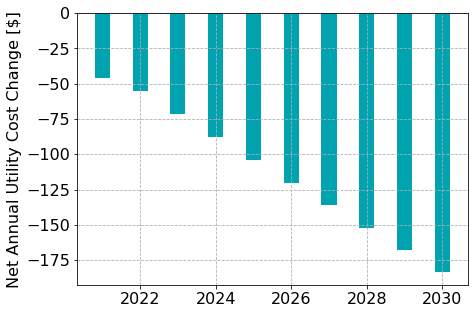

In [67]:
# Visualize
plt.figure(figsize=(7,5))
plt.bar(nat_gas_rate_df.Year,nat_gas_rate_df.Annual_Net_Cost_Change,color=step_blue, align = 'center', width = 0.4)
plt.grid(ls='--')
plt.ylabel('Net Annual Utility Cost Change [$]')